In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.1 MB/s 
     |████████████████████████████████| 7.6 MB 63.7 MB/s 
     |████████████████████████████████| 182 kB 80.5 MB/s 


In [3]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=09deb76e57acd2d0fd8d3ea308044d4941368e62786167fa54627e697da5b792
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [5]:
import wget
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")

'helper_prabowo_ml.py'

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from helper_prabowo_ml import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct, hashtags
from wordcloud import WordCloud
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.metrics import confusion_matrix, classification_report

In [9]:
df = pd.read_csv("/content/train.csv")
df.head()

,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


# check the data

In [10]:
df.shape

(5574, 2)

In [11]:
df.isna().sum()

sms      0
label    0
dtype: int64

In [14]:
df.duplicated().sum()

403

In [15]:
df = df.drop_duplicates()
df.shape

(5171, 2)

In [17]:
df['num_words'] = df.sms.apply(len)
df.num_words.describe()

count    5171.000000
mean       80.332431
std        58.333188
min         3.000000
25%        37.000000
50%        62.000000
75%       120.000000
max       911.000000
Name: num_words, dtype: float64

In [19]:
# max ken is mean len
max_len = 80

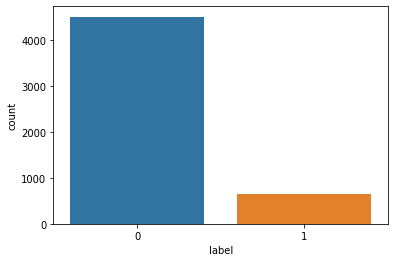

In [20]:
sns.countplot(df.label);

The dataset is highly imbalanced as clearly indicated by the above countplot. The total count of "spam" SMSs is very less as compared to that of legitimate and valid SMSs.

# Text Preprocessing

In [21]:
def text_preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=lower)
    return data

In [22]:
preprocessed_df = text_preprocess(df,'sms')
preprocessed_df.head()

,sms,label,num_words
0,go jurong point crazy available bugis n great ...,0,112
1,ok lar joking wif u oni,0,30
2,free entry wkly comp win fa cup final tkts st ...,1,156
3,u dun say early hor u c already say,0,50
4,nah think goes usf lives around though,0,62


In [23]:
 train_df, test_df = train_test_split(preprocessed_df,test_size=0.3,random_state=42,shuffle=True,stratify=preprocessed_df.label)

# Loading the pretrained Tokenizer class and the pretrained ROBERTA-BASE transformer model

In [24]:
tokenizer = AutoTokenizer.from_pretrained("mariagrandury/roberta-base-finetuned-sms-spam-detection")
roberta = TFAutoModelForSequenceClassification.from_pretrained("mariagrandury/roberta-base-finetuned-sms-spam-detection",from_pt=True)

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/735 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


# Performing text tokenization

In [25]:
X_train = tokenizer(text=train_df.sms.tolist(),
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   add_special_tokens=True,
                   return_tensors="tf",
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=True)
X_test = tokenizer(text=test_df.sms.tolist(),
                  max_length=max_len,
                  padding=True,
                  truncation=True,
                  add_special_tokens=True,
                  return_tensors="tf",
                  return_attention_mask=True,
                  return_token_type_ids=False,
                  verbose=True)

# Fine-tuning the ROBERTA transformer model architecture

In [26]:
input_ids = Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

In [27]:
embeddings = roberta(input_ids,attention_mask=attention_mask)[0] # 0 --> final hidden state, 1 --> pooling output
output = Flatten()(embeddings)
output = Dense(units=1024,activation='relu')(output)
output = Dropout(0.3)(output)
output = Dense(units=512,activation='relu')(output)
output = Dropout(0.2)(output)
output = Dense(units=256,activation='relu')(output)
output = Dropout(0.1)(output)
output = Dense(units=128,activation='relu')(output)
output = Dense(units=2,activation='sigmoid')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=output)
model.layers[2].trainable = True

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 80)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 80)]         0           []                               
                                                                                                  
 tf_roberta_for_sequence_classi  TFSequenceClassifie  124647170  ['input_ids[0][0]',              
 fication (TFRobertaForSequence  rOutput(loss=None,               'attention_mask[0][0]']         
 Classification)                logits=(None, 2),                                                 
                                 hidden_states=None                                           

# Compiling the model

In [29]:
optimizer = Adam(learning_rate=5e-5,epsilon=2e-8,decay=0.01,clipnorm=1.0)
loss = BinaryCrossentropy(from_logits=True)
metrics = BinaryAccuracy('balanced_accuracy')
model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

# Training the fine-tuned ROBERTA transformer model

In [30]:
es = EarlyStopping(monitor='val_balanced_accuracy',patience=20,verbose=1,mode='max')
mc = ModelCheckpoint(filepath='checkpoint',monitor='val_balanced_accuracy',mode='max',save_best_only=True,verbose=1)

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
              y=to_categorical(train_df.label),
              epochs=50,
              batch_size=32,
              callbacks=[es,mc],
              validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.label))
             )

Epoch 1/50
114/114 [==============================] - ETA: 0s - loss: 0.2794 - balanced_accuracy: 0.9218
Epoch 1: val_balanced_accuracy improved from -inf to 0.97874, saving model to checkpoint


114/114 [==============================] - 141s 1s/step - loss: 0.2794 - balanced_accuracy: 0.9218 - val_loss: 0.0833 - val_balanced_accuracy: 0.9787
Epoch 2/50
114/114 [==============================] - ETA: 0s - loss: 0.0626 - balanced_accuracy: 0.9865
Epoch 2: val_balanced_accuracy improved from 0.97874 to 0.98711, saving model to checkpoint


114/114 [==============================] - 119s 1s/step - loss: 0.0626 - balanced_accuracy: 0.9865 - val_loss: 0.0428 - val_balanced_accuracy: 0.9871
Epoch 3/50
114/114 [==============================] - ETA: 0s - loss: 0.0415 - balanced_accuracy: 0.9892
Epoch 3: val_balanced_accuracy did not improve from 0.98711
114/114 [==============================] - 65s 574ms/step - loss: 0.0415 - balanced_accuracy: 0.9892 - val_loss: 0.0393 - val_balanced_accuracy: 0.9858
Epoch 4/50
114/114 [==============================] - ETA: 0s - loss: 0.0240 - balanced_accuracy: 0.9953
Epoch 4: val_balanced_accuracy did not improve from 0.98711
114/114 [==============================] - 65s 571ms/step - loss: 0.0240 - balanced_accuracy: 0.9953 - val_loss: 0.0385 - val_balanced_accuracy: 0.9871
Epoch 5/50
114/114 [==============================] - ETA: 0s - loss: 0.0178 - balanced_accuracy: 0.9967
Epoch 5: val_balanced_accuracy did not improve from 0.98711
114/114 [==============================] - 65s 572m

114/114 [==============================] - 119s 1s/step - loss: 0.0080 - balanced_accuracy: 0.9992 - val_loss: 0.0594 - val_balanced_accuracy: 0.9884
Epoch 10/50
114/114 [==============================] - ETA: 0s - loss: 0.0078 - balanced_accuracy: 0.9992
Epoch 10: val_balanced_accuracy did not improve from 0.98840
114/114 [==============================] - 65s 573ms/step - loss: 0.0078 - balanced_accuracy: 0.9992 - val_loss: 0.0598 - val_balanced_accuracy: 0.9884
Epoch 11/50
114/114 [==============================] - ETA: 0s - loss: 0.0073 - balanced_accuracy: 0.9992
Epoch 11: val_balanced_accuracy did not improve from 0.98840
114/114 [==============================] - 65s 570ms/step - loss: 0.0073 - balanced_accuracy: 0.9992 - val_loss: 0.0653 - val_balanced_accuracy: 0.9865
Epoch 12/50
114/114 [==============================] - ETA: 0s - loss: 0.0076 - balanced_accuracy: 0.9992
Epoch 12: val_balanced_accuracy improved from 0.98840 to 0.98905, saving model to checkpoint


114/114 [==============================] - 117s 1s/step - loss: 0.0076 - balanced_accuracy: 0.9992 - val_loss: 0.0654 - val_balanced_accuracy: 0.9890
Epoch 13/50
114/114 [==============================] - ETA: 0s - loss: 0.0073 - balanced_accuracy: 0.9992
Epoch 13: val_balanced_accuracy did not improve from 0.98905
114/114 [==============================] - 65s 573ms/step - loss: 0.0073 - balanced_accuracy: 0.9992 - val_loss: 0.0657 - val_balanced_accuracy: 0.9890
Epoch 14/50
114/114 [==============================] - ETA: 0s - loss: 0.0071 - balanced_accuracy: 0.9992
Epoch 14: val_balanced_accuracy did not improve from 0.98905
114/114 [==============================] - 65s 570ms/step - loss: 0.0071 - balanced_accuracy: 0.9992 - val_loss: 0.0673 - val_balanced_accuracy: 0.9890
Epoch 15/50
114/114 [==============================] - ETA: 0s - loss: 0.0073 - balanced_accuracy: 0.9992
Epoch 15: val_balanced_accuracy did not improve from 0.98905
114/114 [==============================] - 65

114/114 [==============================] - 117s 1s/step - loss: 0.0081 - balanced_accuracy: 0.9989 - val_loss: 0.0759 - val_balanced_accuracy: 0.9897
Epoch 27/50
114/114 [==============================] - ETA: 0s - loss: 0.0076 - balanced_accuracy: 0.9989
Epoch 27: val_balanced_accuracy did not improve from 0.98969
114/114 [==============================] - 65s 573ms/step - loss: 0.0076 - balanced_accuracy: 0.9989 - val_loss: 0.0711 - val_balanced_accuracy: 0.9878
Epoch 28/50
114/114 [==============================] - ETA: 0s - loss: 0.0072 - balanced_accuracy: 0.9992
Epoch 28: val_balanced_accuracy did not improve from 0.98969
114/114 [==============================] - 65s 569ms/step - loss: 0.0072 - balanced_accuracy: 0.9992 - val_loss: 0.0713 - val_balanced_accuracy: 0.9878
Epoch 29/50
114/114 [==============================] - ETA: 0s - loss: 0.0064 - balanced_accuracy: 0.9992
Epoch 29: val_balanced_accuracy did not improve from 0.98969
114/114 [==============================] - 65

# Analyzing the overall performance of the fine-tuned ROBERTA transformer model

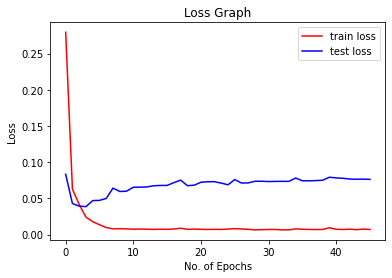

In [31]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

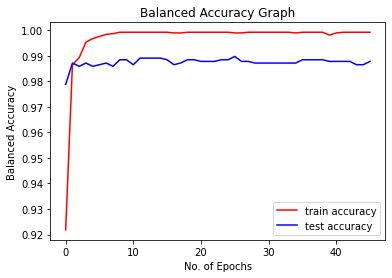

In [32]:
plt.plot(r.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Graph')
plt.legend();

# Saving the model

In [33]:
model.save('sms_spam_detector.h5')

# Model Evaluation

In [34]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.label))
print("Test Binary Crossentropy Loss:", loss)
print("Test Binary Accuracy:", acc)

49/49 [==============================] - 8s 164ms/step - loss: 0.0762 - balanced_accuracy: 0.9878
Test Binary Crossentropy Loss: 0.07621361315250397
Test Binary Accuracy: 0.9877577424049377


In [36]:
import numpy as np

test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print("Confusion Matrix:")
print(confusion_matrix(test_df.label,test_predictions))
print("Classification Report:")
print(classification_report(test_df.label,test_predictions))

49/49 [==============================] - 8s 163ms/step
Confusion Matrix:
[[1348    8]
 [  11  185]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1356
           1       0.96      0.94      0.95       196

    accuracy                           0.99      1552
   macro avg       0.98      0.97      0.97      1552
weighted avg       0.99      0.99      0.99      1552



The fine-tuned ROBERTA-BASE SMS Spam detection transformer model has produced an outstanding balanced accuracy of more than 99% on the test set.